In [4]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# %matplotlib inline

# Advanced Lane Detection

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# prepare object points
nx = 6
ny = 8

# prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

# Make a list of calibration images
fname = 'camera_cal/calibration2.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#fig, axes= plt.subplots(1, 2, figsize=(30,30))
#axes[0].set_title("original", fontsize=20)
#axes[0].imshow(img)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    objpoints.append(objp)
    imgpoints.append(corners)
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    #plt.imshow(img)
    #axes[1].set_title("with corners", fontsize=20)

In [6]:

img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (img.shape[1], img.shape[0])

_ , mtx, dist, _ , _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
img_undis = cv2.undistort(img, mtx, dist, None, mtx)

# fig, axes= plt.subplots(1, 2, figsize=(30, 30))
# axes[0].set_title("original", fontsize=20)
# axes[0].imshow(img)
# axes[1].set_title("undistorted", fontsize=20)
# axes[1].imshow(img_undis)

In [7]:
# define function for undistorting

def Undistort_Image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

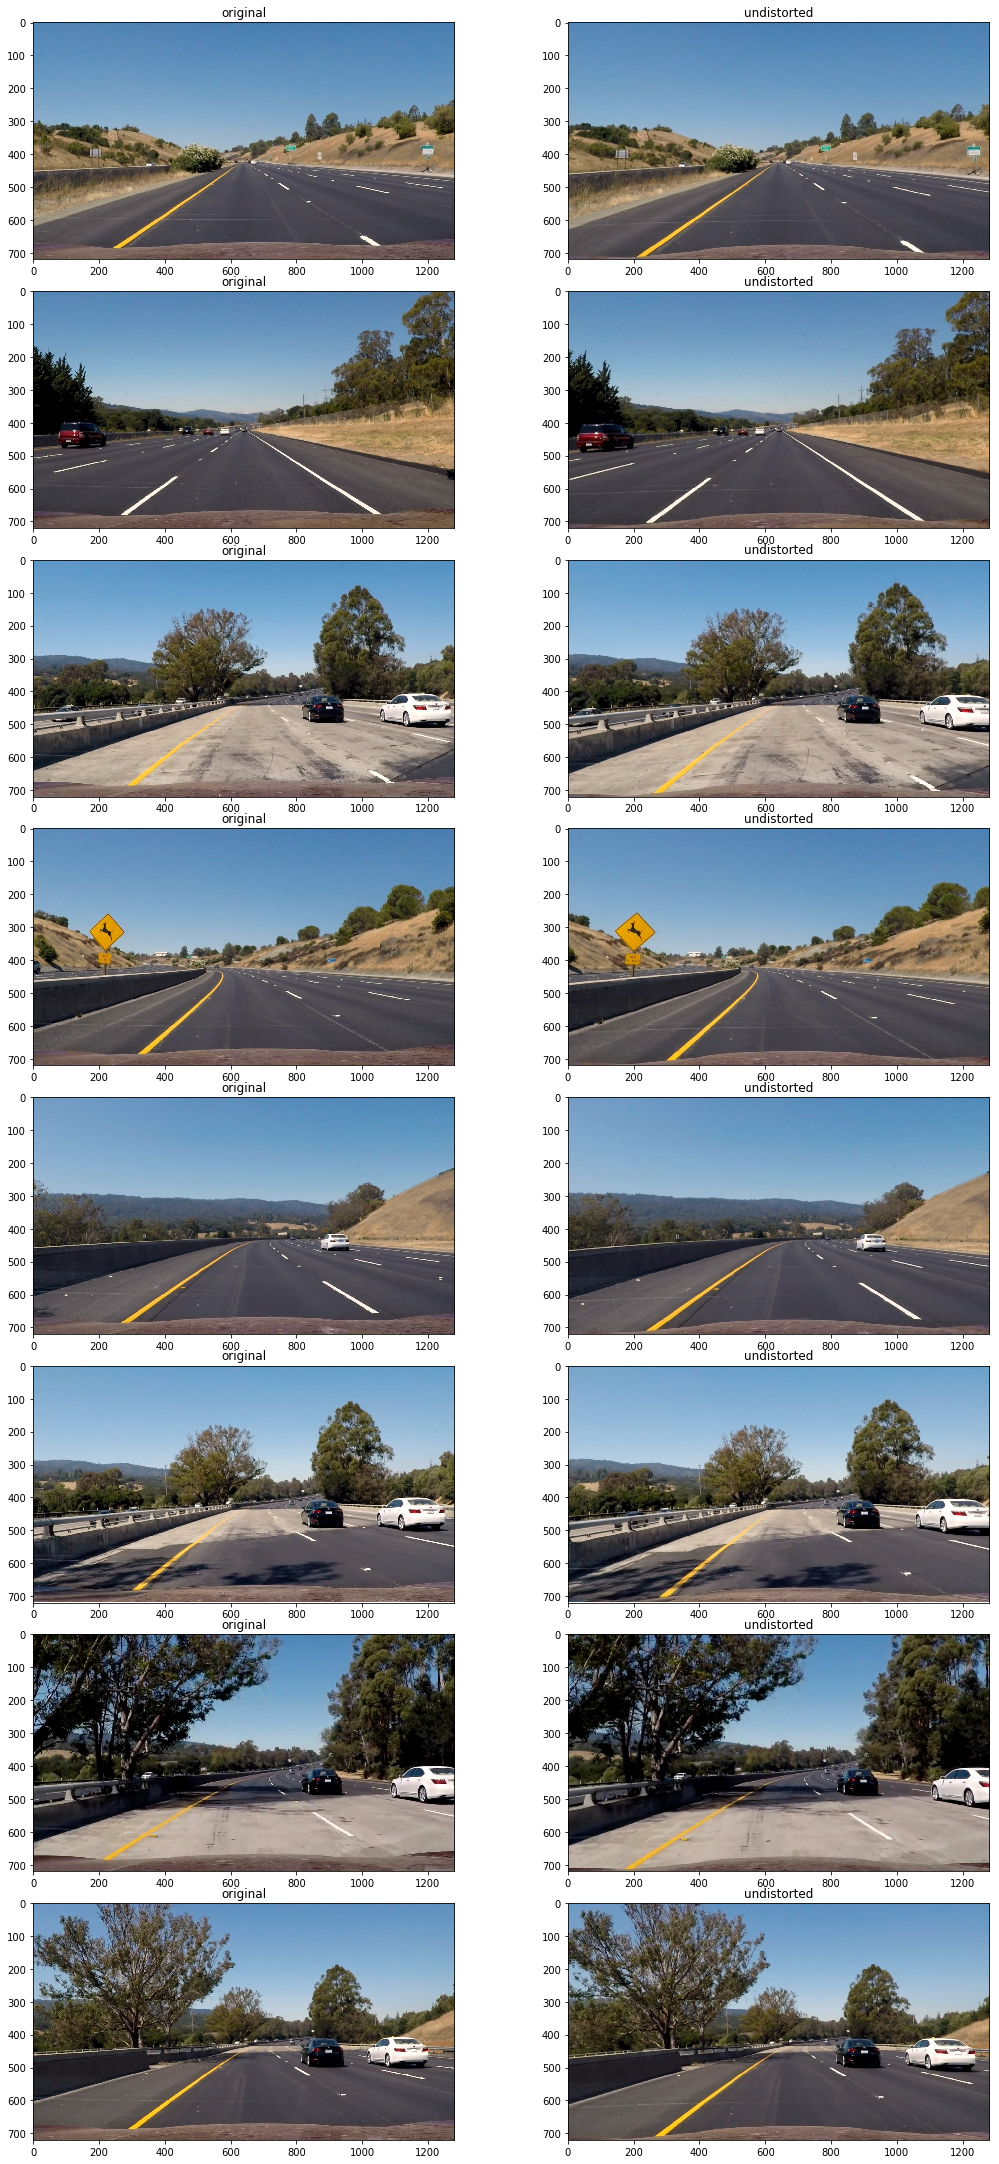

In [8]:
# try test images

fig, axes = plt.subplots(8, 2, figsize=(15, 30))
plt.tight_layout()

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder
originals = []

for idx, img in enumerate(images):
    original = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    originals.append(original)
    axes[idx, 0].imshow(original)
    axes[idx, 0].set_title("original")
    img_undist = Undistort_Image(original) # undistorting image 
    axes[idx, 1].set_title("undistorted")
    axes[idx, 1].imshow(img_undist)

### 3) Region of Interest & Warping

In [9]:
# warp from source points to destination points (left down, left_up, right_down, right_up)
# the shape is from a distorted trapezoid (trapezium) to a trapezoid

# downleft, upleft, downright, upright
src = np.float32([[150,720], [590,450], [700,450], [1250,720]])
dst = np.float32([[200,720], [200,0], [980,0], [980,720]])

def ROI(original):
    img_roi = cv2.polylines(original, np.int32(np.array([[[150,720], [590,450], [700,450], [1250,720]]])), True, 
                            (0,0,255), 10)
    return img_roi

def Warp(original):
    # M is the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(original, M, (original.shape[1],original.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

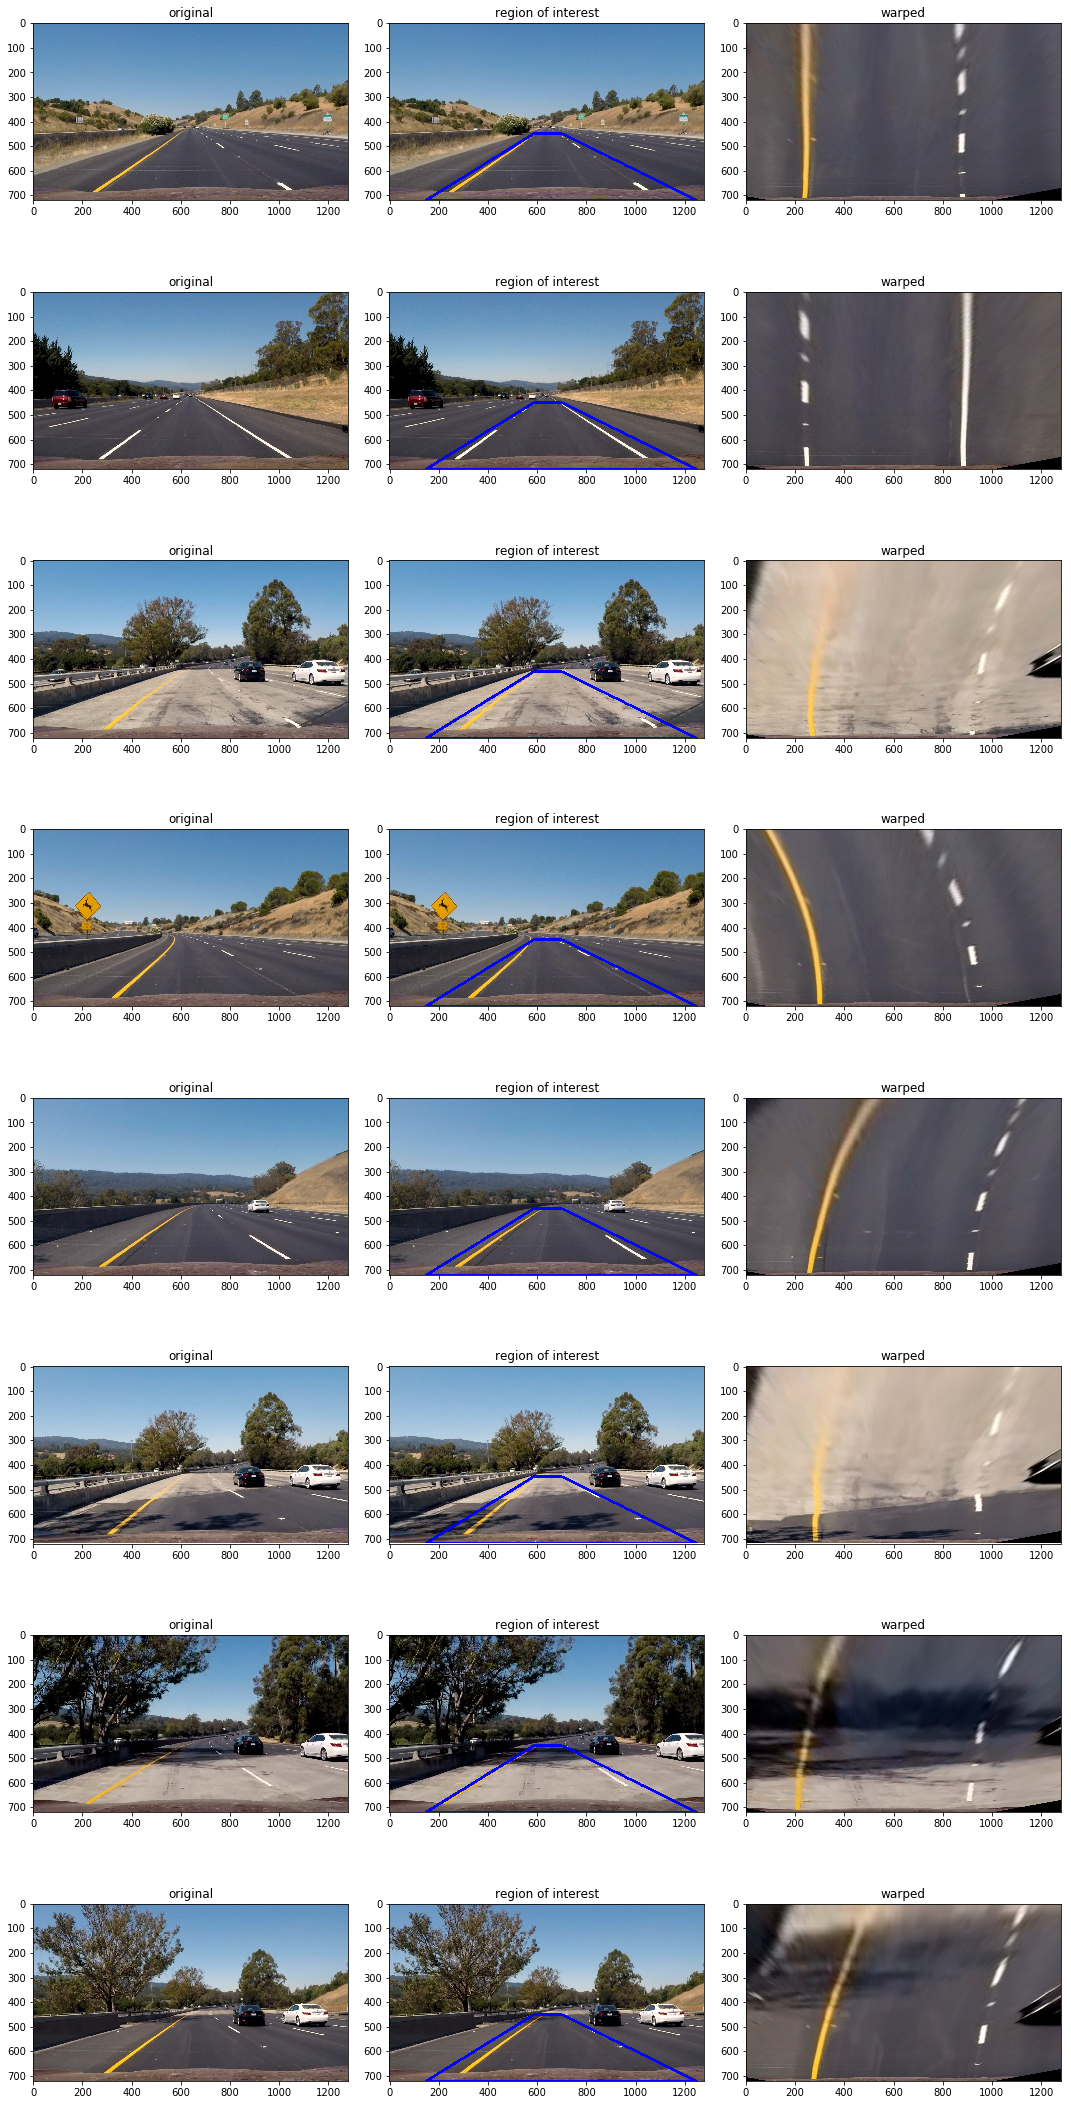

In [10]:
# try test images

fig, axes= plt.subplots(8, 3, figsize=(15, 30))
plt.tight_layout()

warped_images = []

for idx, img in enumerate(images):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    
    original = image.copy()
    axes[idx,0].imshow(original)
    axes[idx,0].set_title("original")
    
    img_roi = ROI(image)
    axes[idx,1].set_title("region of interest")
    axes[idx,1].imshow(img_roi)
    
    img_warp = Warp(original)
    warped_images.append(img_warp)
    axes[idx,2].set_title("warped")
    axes[idx,2].imshow(img_warp)

### 4) Color Space Selection

In [11]:
def Extract_Channel(image, colorspace, threshold, channel=0):
    colorspace = cv2.cvtColor(image, colorspace)
    channels = colorspace[:, :, channel]
    binary = np.zeros_like(channels)    
    # bitwise operator "and"
    binary[(channels >= threshold[0]) & (channels <= threshold[1])] = 1
    return binary

Text(0.5,1,'V')

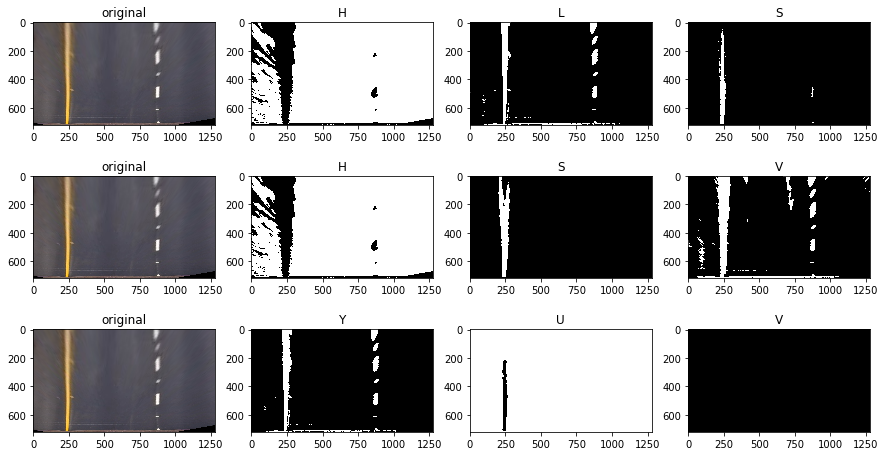

In [12]:
# try different color spaces using warped images
# notice how the output of L,S,Y are the most distinct

fig, axes= plt.subplots(3, 4, figsize=(15, 8))

rand_idx = np.random.randint(0, 7)
image = warped_images[rand_idx]

threshold=[100, 255]
index = 0
axes[index, 0].imshow(image)
axes[index, 0].set_title("original")

axes[index+1, 0].imshow(image)
axes[index+1, 0].set_title("original")

axes[index+2, 0].imshow(image)
axes[index+2, 0].set_title("original")


# HLS Colorspace
h = Extract_Channel(image, cv2.COLOR_RGB2HLS ,threshold, 0)
axes[index, 1].imshow(h, cmap='gray')
axes[index, 1].set_title("H")

l = Extract_Channel(image, cv2.COLOR_RGB2HLS ,threshold, 1)
axes[index, 2].imshow(l, cmap='gray')
axes[index, 2].set_title("L")

s = Extract_Channel(image, cv2.COLOR_RGB2HLS ,threshold, 2)
axes[index, 3].imshow(s, cmap='gray')
axes[index, 3].set_title("S")

# HSV Colorspace
h = Extract_Channel(image, cv2.COLOR_RGB2HSV ,threshold, 0)
axes[index+1, 1].imshow(h, cmap='gray')
axes[index+1, 1].set_title("H")

s = Extract_Channel(image, cv2.COLOR_RGB2HSV ,threshold, 1)
axes[index+1, 2].imshow(s, cmap='gray')
axes[index+1, 2].set_title("S")

v = Extract_Channel(image, cv2.COLOR_RGB2HSV ,threshold, 2)
axes[index+1, 3].imshow(v, cmap='gray')
axes[index+1, 3].set_title("V")

# YUV Colorspace
y = Extract_Channel(image, cv2.COLOR_RGB2YUV ,threshold, 0)
axes[index+2, 1].imshow(y, cmap='gray')
axes[index+2, 1].set_title("Y")

u = Extract_Channel(image, cv2.COLOR_RGB2YUV ,threshold, 1)
axes[index+2, 2].imshow(u, cmap='gray')
axes[index+2, 2].set_title("U")

v = Extract_Channel(image, cv2.COLOR_RGB2YUV ,threshold, 2)
axes[index+2, 3].imshow(v, cmap='gray')
axes[index+2, 3].set_title("V")

### 5) Apply Sobel

In [13]:
def Apply_Sobel(warped, threshold, sobel_type, kernel=3):
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel))
    
    grad = np.sqrt(abs_sobelx**2, abs_sobely**2)
    # need to be arctan2 for correct angles
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    parameter = []
    if sobel_type == 'x':
        parameter = abs_sobelx
    elif sobel_type == 'y':
        parameter = abs_sobely
    elif sobel_type == 'xy':
        parameter = grad
    elif sobel_type == 'dir':
        parameter = arctan
    else:
        pass
    
    # normalization
    image = np.uint8((parameter * 255) / np.max(parameter))
    binary = np.zeros_like(image)
    # bitwise operator "and"
    binary[(image > threshold[0]) & (image < threshold[1])] = 1
    return binary

Text(0.5,1,'Direction')

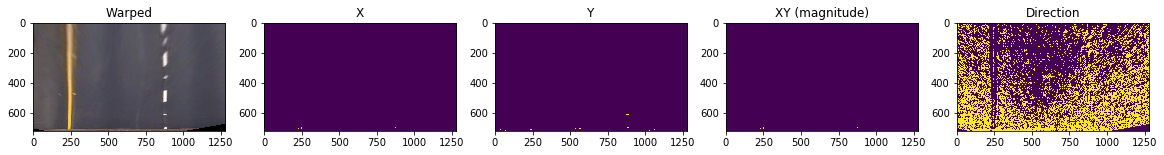

In [14]:
# testing sobel on warped image
fig, axes= plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(image)
axes[0].set_title("Warped")

sobelx = Apply_Sobel(image, threshold, 'x')
axes[1].imshow(sobelx)
axes[1].set_title("X")

sobely = Apply_Sobel(image, threshold, 'y')
axes[2].imshow(sobely)
axes[2].set_title("Y")

sobelxy = Apply_Sobel(image, threshold, 'xy')
axes[3].imshow(sobelxy)
axes[3].set_title("XY (magnitude)")

sobeldir = Apply_Sobel(image, threshold, 'dir')
axes[4].imshow(sobeldir)
axes[4].set_title("Direction")

### 6) Combining Color Spaces and Sobel Variants

In [15]:
def combine(warped, color_th, sobel_th):
    # best combination shown in color space section
    l_channel = Extract_Channel(warped, cv2.COLOR_RGB2HLS, color_th, 1)
    s_channel = Extract_Channel(warped, cv2.COLOR_RGB2HLS, color_th, 2)
    y_channel = Extract_Channel(warped, cv2.COLOR_RGB2YUV, color_th, 0)
    
    # sobel x is superior since roads are much more vertical than horizontal
    sobelx = Apply_Sobel(warped, sobel_th, 'x')
    sobeldir = Apply_Sobel(warped, sobel_th, 'dir')
    
    binary = np.zeros_like(l_channel)
    # all l s y channels have to be 1, sobelx is very accurateon on its own as shown in output above so use "or"
    binary[(((l_channel == 1) & (s_channel == 1)) & (y_channel == 1)) | (sobelx == 1)] = 1
    return binary

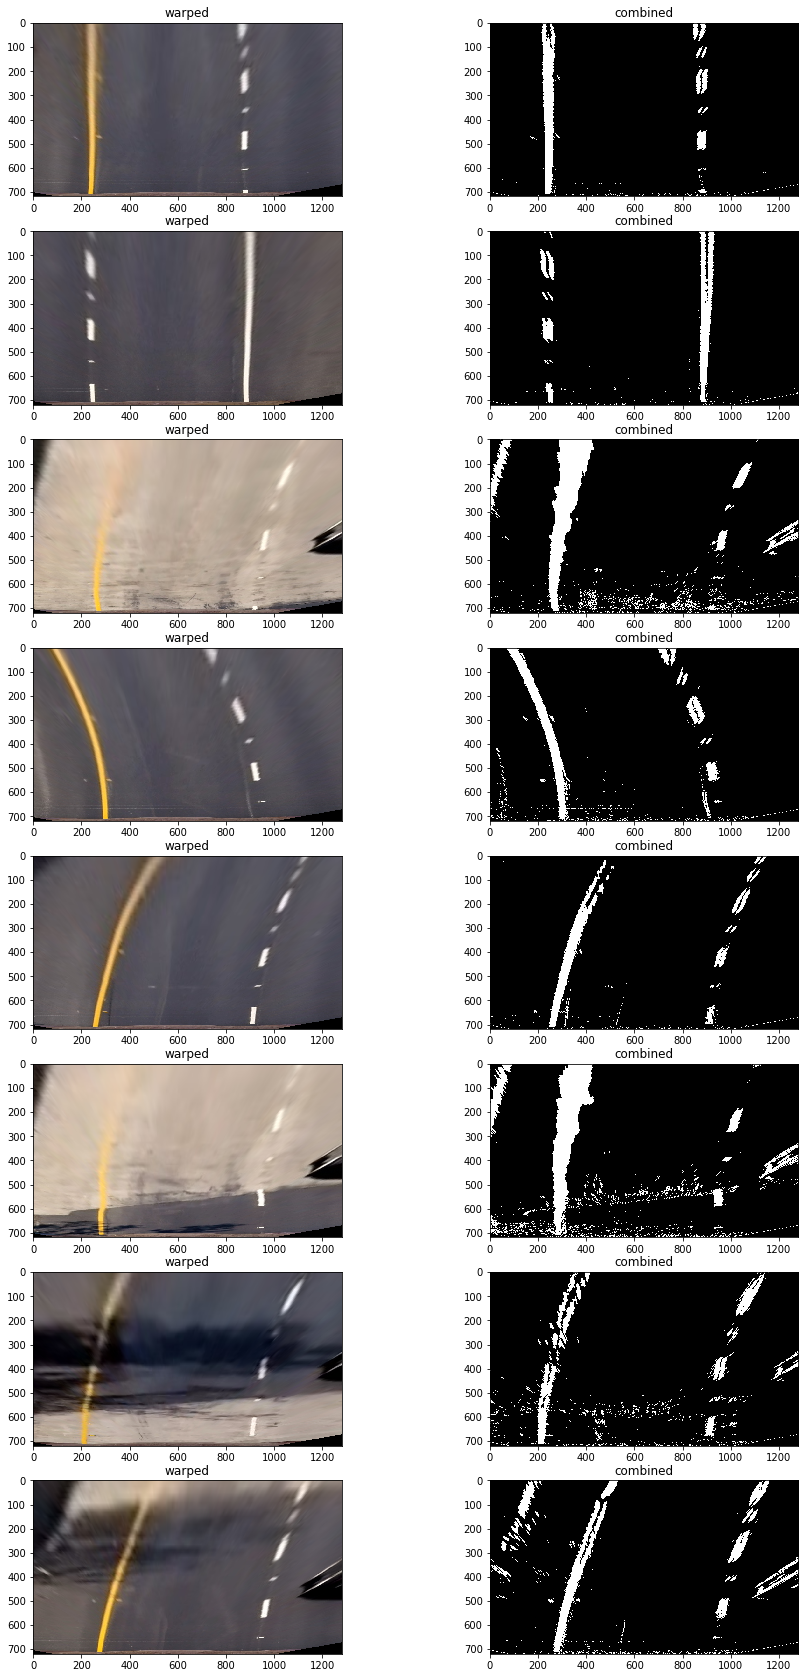

In [16]:
# test on warped images
# as shown by the output, the process has captured lanes very well (even the broken lines)
fig, axes = plt.subplots(8,2,figsize=(15, 30))

for idx,warped in enumerate(warped_images):
    combined=combine(warped, [100, 255], [10, 150])
    axes[idx,0].imshow(warped)
    axes[idx,0].set_title("warped")
    axes[idx,1].imshow(combined,cmap='gray')
    axes[idx,1].set_title("combined")

### 7) Plot Histogram

In [17]:
# draw histogram of how the clustering of coordinates wrt the width
def Histogram(warped):
    half_height = warped.shape[0] // 2
    data = np.sum(warped[half_height//2:, :], axis=0)
    return data

Text(0.5,1,'histogram')

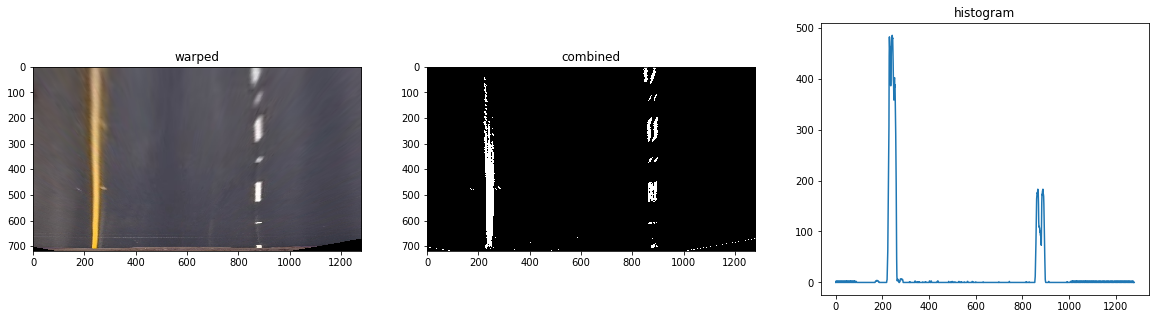

In [18]:
# testing on warped images

fig, axes= plt.subplots(1,3,figsize=(20,5))
axes[0].imshow(image)
axes[0].set_title("warped")
combined = combine(image,[150,255],[20,100])
axes[1].imshow(combined,cmap="gray")
axes[1].set_title("combined")
hist_data = Histogram(combined)
axes[2].plot(hist_data)
axes[2].set_title("histogram")

### 8) Find Lanes

In [19]:
# the sliding window search cuts the image horizontally into multiple strips and finds the histogram of each strip
def Sliding_Window(binary, plot):
    histogram = Histogram(binary)
    image = np.dstack((binary, binary, binary)) * 255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    num_windows = 9
    window_h = np.int(binary.shape[0] / num_windows)
    
    # nonzero() returns two arrays of x y coordinates that are not zero
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_curr = leftx_base
    rightx_curr = rightx_base
    
    # include points in a +/-100 window
    margin = 100
    # at least 50 pixels in 200 width window for there to be a line
    min_pixel = 50
    
    left_lane_idc = []
    right_lane_idc = []
    
    for win in range(num_windows):
        win_y_low = binary.shape[0] - (win + 1) * window_h
        win_y_high = win_y_low + window_h
        win_xl_low = leftx_curr - margin
        win_xl_high = leftx_curr + margin
        win_xr_low = rightx_curr - margin
        win_xr_high = rightx_curr + margin
        
        if plot:
            cv2.rectangle(image, (win_xl_low, win_y_low), (win_xl_high, win_y_high), (0,255,0),2)
            cv2.rectangle(image, (win_xr_low, win_y_low), (win_xr_high, win_y_high), (0,255,0),2)
        
        # get valid x y coordinates in the window
        good_left_idc = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xl_low) & (nonzerox <= win_xl_high)).nonzero()[0]
        good_right_idc = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xr_low) & (nonzerox <= win_xr_high)).nonzero()[0]
        
        left_lane_idc.append(good_left_idc)
        right_lane_idc.append(good_right_idc)
        
        # update curr for plotting
        if len(good_left_idc) > min_pixel:
            leftx_curr = np.int(np.mean(nonzerox[good_left_idc]))
        if len(good_right_idc) > min_pixel:
            rightx_curr = np.int(np.mean(nonzerox[good_right_idc]))
         
    left_lane_idc = np.concatenate(left_lane_idc)
    right_lane_idc = np.concatenate(right_lane_idc)
        
    leftx = nonzerox[left_lane_idc]
    rightx = nonzerox[right_lane_idc]
    lefty = nonzeroy[left_lane_idc]
    righty = nonzeroy[right_lane_idc]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_idc, right_lane_idc, image
        

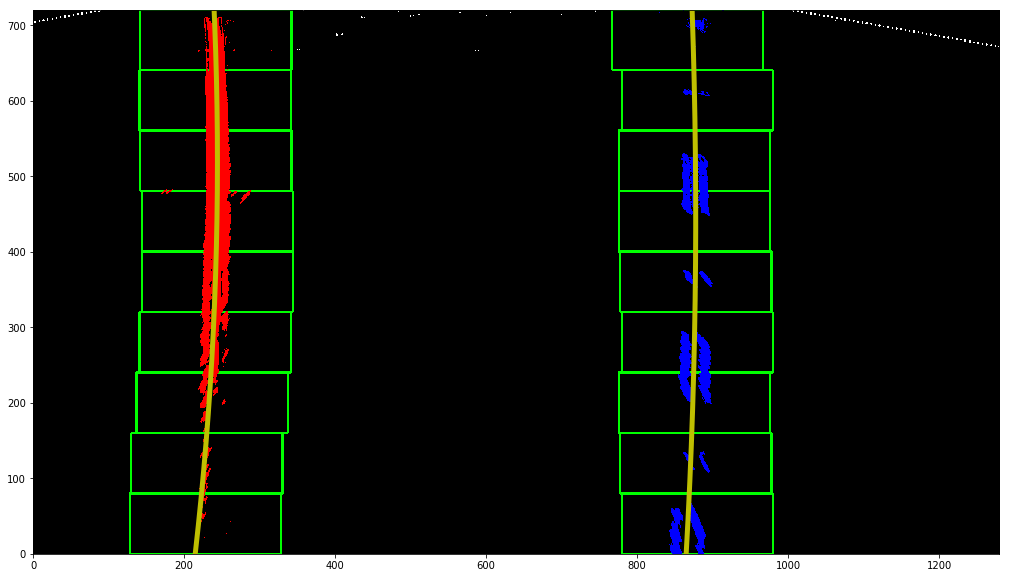

In [21]:
# test sliding window function

def Visualize_Windows(binary, left_fit, right_fit, left_lane_idc, right_lane_idc, image):
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    image[nonzeroy[left_lane_idc], nonzerox[left_lane_idc]] = [255,0,0]
    image[nonzeroy[right_lane_idc], nonzerox[right_lane_idc]] = [0,0,255]

    # generate points of poly curve
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.plot(left_fitx, ploty, color='y',lw=5)
    plt.plot(right_fitx, ploty, color='y',lw=5)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    
left_fit, right_fit, left_lane_idc, right_lane_idc, image = Sliding_Window(combined, plot=True)
Visualize_Windows(combined, left_fit, right_fit, left_lane_idc, right_lane_idc, image)

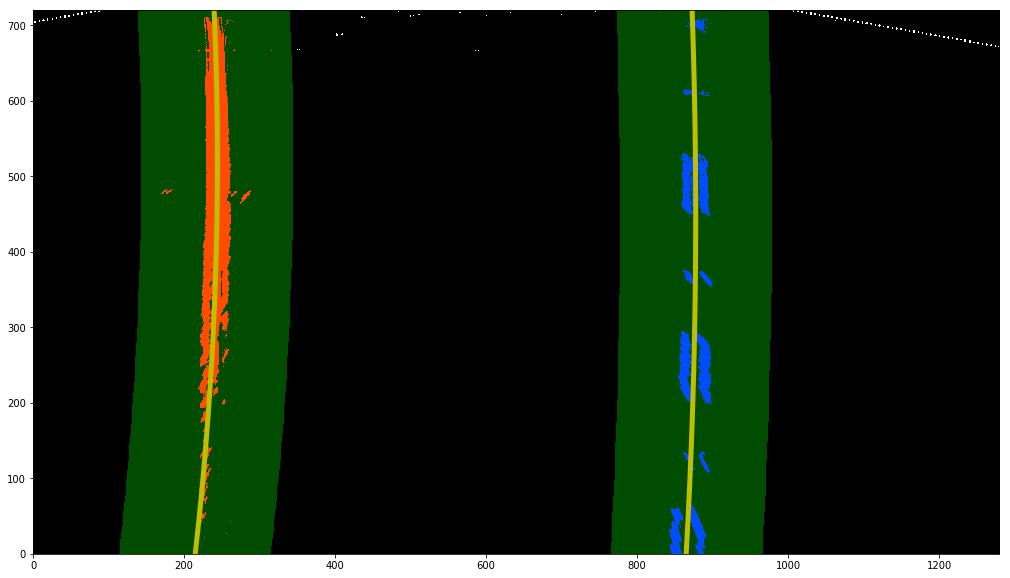

In [38]:
# smoothen the windows into a two planes

def Visualize_Lanes(binary, left_fit, right_fit, left_lane_idc, right_lane_idc, image):
    margin = 100
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty +left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # create image and lane, they will be added together by the end
    image = np.dstack((binary,binary,binary)) * 255
    lane = np.zeros_like(image)
    
    image[nonzeroy[left_lane_idc], nonzerox[left_lane_idc]] = [255, 0, 0]
    image[nonzeroy[right_lane_idc], nonzerox[right_lane_idc]] = [0, 0, 255]
    
    # advanced plotting technique
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(lane, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(lane, np.int_([right_line_pts]), (0, 255, 0))
    lane_image = cv2.addWeighted(image, 1, lane, 0.3, 0)
    
    plt.figure(figsize=(20,10))
    plt.imshow(lane_image)
    plt.plot(left_fitx, ploty, color='y', lw=5)
    plt.plot(right_fitx, ploty, color='y', lw=5)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)

left_fit, right_fit, left_lane_idc, right_lane_idc, image = Sliding_Window(combined, plot=False)
Visualize_Lanes(combined, left_fit, right_fit, left_lane_idc, right_lane_idc, image)

### 9) Unwarp Lane Image

In [26]:
# remember how we warped the image into bird-eye view for detection? now we have to warp the detections back

def Draw_Line(original, binary, left_fit, right_fit):
    h, w = binary.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary.shape[0] - 1, binary.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty +left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # reassign ploty to an array fitting the camera image
    ploty = np.linspace(0, h-1, h)
    # cast to fillPoly format
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 0, 255), thickness=10)
    
    unwarp = cv2.warpPerspective(color_warp, Minv, (w,h))
    lane_image_unwarp = cv2.addWeighted(original, 1, unwarp, 0.3, 0)
    
    return lane_image_unwarp

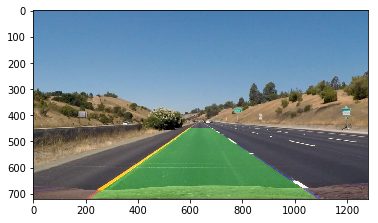

In [28]:
# test using original test image

original = images[0]
original = cv2.cvtColor(cv2.imread(original), cv2.COLOR_BGR2RGB)

left_fit, right_fit, left_lane_idc, right_lane_idc, image = Sliding_Window(combined, plot=False)

lane_image_unwarp = Draw_Line(original, combined, left_fit, right_fit)
plt.imshow(lane_image_unwarp)

### 10) Calculate Curvature

In [33]:
# calculate the radius of curvature of the lane, very glad to apply my knowledge of calculus here

def Radius_Of_Curvature(binary, left_fit, right_fit):
    # meter per pixel
    ym_per_p = 30 / 720 
    xm_per_p = 3.7 / 700
    
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    leftx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    rightx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # horizontal center of image
    position = binary.shape[1] / 2
    
    # fit new curve in camera perspective
    left_fit_cr = np.polyfit(ploty * ym_per_p, leftx * xm_per_p, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_p, rightx * xm_per_p, 2)
    
    y_eval = np.max(ploty) # y value at bottom of page
    left_rad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_p + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_rad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_p + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    curve_rad = (left_rad+right_rad)/2
    
    # actual bottom 
    left_lane_bottom = (left_fit[0] * y_eval) ** 2 + left_fit[0] * y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0] * y_eval) ** 2 + right_fit[0] * y_eval + right_fit[2]
    actual_pos = (left_lane_bottom + right_lane_bottom)/2
    
    dist = (position - actual_pos) * xm_per_p
    
    return curve_rad, dist

In [34]:
# test with combined binary

print(Radius_Of_Curvature(combined, left_fit, right_fit))

(2045.943231124806, 0.5293888204389284)


### 11) Construct Pipeline

In [35]:
import datetime
import time

# its crazy how much is done to just one input image!
def Pipeline(original):
# original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    undistorted = Undistort_Image(original)
    warped = Warp(undistorted)
    combined = combine(warped, color_th=[100,255], sobel_th=[10,150])
    left_fit, right_fit, left_lane_idc, right_lane_idc, image = Sliding_Window(combined, False)
    result = Draw_Line(original, combined, left_fit, right_fit)
    
    radius, distance = Radius_Of_Curvature(combined, left_fit, right_fit)
    cv2.putText(result, "Radius of Curvature: " + str(int(radius))+"m", (100,100), 2, 1, (0,255,255), 2)
    cv2.putText(result, "Horizontal center offset: {:2f}".format(distance)+"m", (100,150), 2, 1, (0,255,255), 2)

    return result

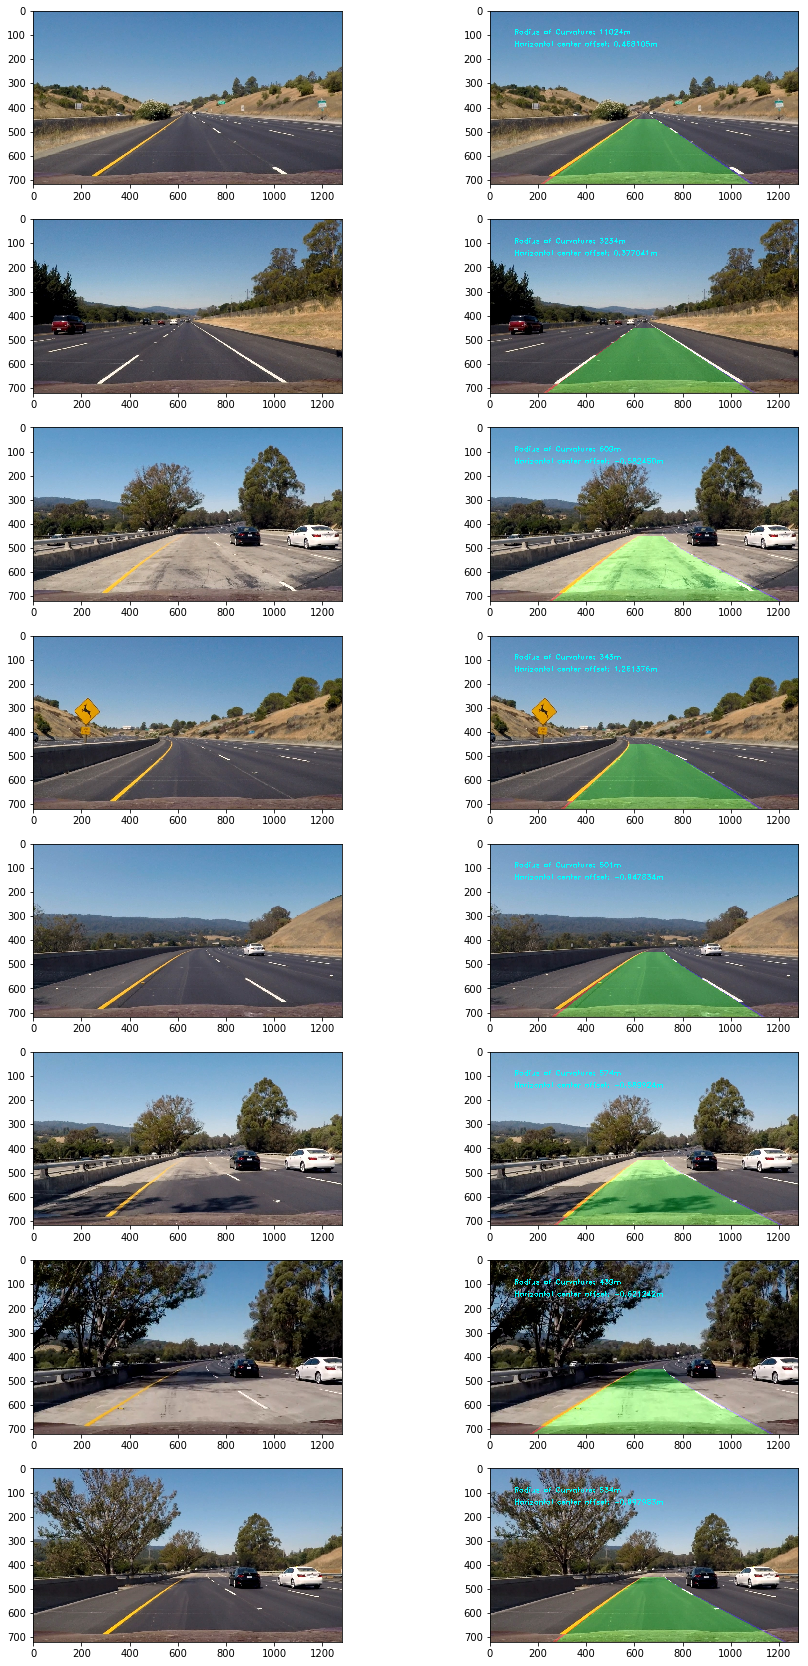

In [36]:
# try pipline with test images\
fig, axes = plt.subplots(8, 2, figsize=(15, 30))
images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

for idx, img in enumerate(images):
    original = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    result = Pipeline(original)
    cv2.imwrite('output_images/output_' + str(idx) + '.jpg', cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    axes[idx, 0].imshow(original)
    axes[idx, 1].imshow(result)

### 12) Process Video

In [36]:
import imageio
imageio.plugins.ffmpeg.download()

In [ ]:
import moviepy
from moviepy.editor import VideoFileClip
# using the moviepy filter
processed_video = VideoFileClip('input_videos/vid.mp4').fl_image(Pipeline)
%time processed_video.write_videofile('output_videos/vid_result.mp4', audio=False)

In [ ]:
processed_video = VideoFileClip('videos/vid_trimmed.mp4').fl_image(Pipeline)
%time processed_video.write_videofile('output_videos/vid_trimmed_result.mp4', audio=False)

In [ ]:
VideoFileClip('videos/vid_trimmed.mp4').write_gif('vid_trimmed.gif')